<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Исследование-баланса-классов" data-toc-modified-id="Исследование-баланса-классов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование баланса классов</a></span></li><li><span><a href="#Учет-дисбаланса-классов" data-toc-modified-id="Учет-дисбаланса-классов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Учет дисбаланса классов</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов банка  

## Описание проекта  

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.  

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.  

Необходимо построить модель с предельно большим значением F1-меры и довести метрику до 0.59. Проверить F1-меру на тестовой выборке. Дополнительно измерить *AUC-ROC*, сравнивая её значение с F1-мерой.  

**Ход выполнения проекта**  

Проект будем выполнять в 4 этапа:
1. Загрузим и подготовим данные;
2. Исследуем баланс классов, обучим модель без учета дисбаланса;  
3. Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую;
4. Проведем финальное тестирование.  

**Описание данных**  

Данные находятся в файле `/datasets/Churn.csv`  (англ. «отток клиентов»).  

**Признаки:**  
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата  

**Целевой признак:**  
* `Exited` — факт ухода клиента

## Загрузка и подготовка данных

In [1]:
# для вывода общей информации установим пакет ydata-profiling
!pip install -U ydata-profiling[notebook]

In [2]:
# включим использование виджетов
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from ydata_profiling import ProfileReport

import warnings

In [4]:
# увеличим максимальное количество отображаемых столбцов
pd.set_option('display.max_columns', None)

# Вывести из под комментария перед финальным запуском:
# Игнорируем предупреждения о возможных изменения работы фуфнкций в будущих версиях в Pandas
warnings.filterwarnings("ignore") 

In [5]:
# считывание csv-файла
try: 
    main_df = pd.read_csv('/datasets/Churn.csv')
except:
    main_df = pd.read_csv('Churn.csv')

In [6]:
# зададим значение random_state, которое будет использоваться на протяжении всего проекта
RANDOM_STATE = 12345

In [7]:
# выведем первые 10 строк датафрейма
main_df.head(10)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   
5          6    15574012       Chu          645     Spain    Male   44   
6          7    15592531  Bartlett          822    France    Male   50   
7          8    15656148    Obinna          376   Germany  Female   29   
8          9    15792365        He          501    France    Male   44   
9         10    15592389        H?          684    France    Male   27   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   
5     8.0  113755.78              2          1               0   
6     7.0       0.00              2          1               1   
7     4.0  115046.74              4          1               0   
8     4.0  142051.07              2          0               1   
9     2.0  134603.88              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0  
5        149756.71       1  
6         10062.80       0  
7        119346.88       1  
8         74940.50       0  
9         71725.73       0

In [8]:
# переименуем столбцы в соответствии с хорошим стилем
main_df = main_df.rename(columns={'RowNumber': 'row_number',
                       'CustomerId': 'customer_id',
                        'Surname': 'surname',
                        'CreditScore': 'credit_score',
                        'Geography': 'geography',
                        'Gender': 'gender',
                        'Age': 'age',
                        'Tenure': 'tenure',
                        'Balance': 'balance',
                        'NumOfProducts': 'num_of_products',
                        'HasCrCard': 'has_cr_card',
                        'IsActiveMember': 'is_active_member',
                        'EstimatedSalary': 'estimated_salary',
                        'Exited': 'exited',
                       })

In [9]:
# выведем общую информацию о таблице
ProfileReport(main_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Проведя первичный анализ данных получили следующее:  
* в таблице 10тыс. значений, 14 столбцов;   
* в столбце `tenure` (сколько лет человек является клиентом банка) имеется 909 пропусков - 9,1%;  
* 36,2% значений с нулевым балансом на счете;   

Основная цель проекта - обучение модели оттока клиентов банка на имеющихся данных. В таблице имеем столбцы, не несущие в себе полезной информации для модели - выделим мусорные признаки:
* `row_number` - индекс строк не несёт в себе никакой информации;
* `customer_id` - уникальный идентификатор клиента не является признаком, ценным для обучения модели;
* `surname` - фамилия клиента также не является ценным признаком для обучения модели.  

Также для обучения потребуется преобразовать техникой прямого кодирования (*OHE*) следующие столбцы:
* `georgaphy` - 3 уникальных значения: *France, Germany, Spain*
* `gender` - 2 значения *male* и *female*

### Подготовка данных  

Создадим копию датафрейма, чтобы убедиться, что данные не испорчены после предобработки

In [10]:
df = main_df.copy(deep=True)

### Проверка дубликатов  

Проверим наличие дубликатов в значении идентификатора клиента

In [11]:
df['customer_id'].duplicated().sum()

0

Все клиенты являются уникальными.  
Выведем количество всех дубликатов в таблице.

In [12]:
df.duplicated().sum()

0

Дубликаты отсутствуют.

### Удаление столбцов  

Удалим столбцы - мусорные признаки, которые обозначили выше (т.к. они не пригодятся при обучении модели)

In [13]:
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

### Обработка пропусков  

Пропуски имеются только в одном столбце - `tenure` (сколько лет человек является клиентом банка). Заполним пропуски медианным значением в зависимости от возраста клиента (столбец `age`)

In [14]:
# сгруппируем и преобразуем в медианные значения по возрасту клиента
df_tenure = df.groupby('age')['tenure'].transform('median')
# заполним пропуски медианным значением
df['tenure'] = df['tenure'].fillna(df_tenure)
# выведем информацию о столбце tenure после изменений
df['tenure'].describe()

count    10000.000000
mean         4.995800
std          2.762118
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: tenure, dtype: float64

На всякий случай проверим какой объем данных отсеялся после подготовки данных

In [15]:
1 - (df.shape[0] / main_df.shape[0])

0.0

### Преобразование признаков  

Преобразуем категориальные признаки в численные с помощью метода прямого кодирования (*OHE*). Это позволит использовать следующие модели: дерево решений, случайный лес, логистическую регрессию.

In [16]:
df = pd.get_dummies(df, drop_first=True)

# выведем первые 10 столбцов обновленного датафрейма
df.head(10)

credit_score  age  tenure    balance  num_of_products  has_cr_card  \
0           619   42     2.0       0.00                1            1   
1           608   41     1.0   83807.86                1            0   
2           502   42     8.0  159660.80                3            1   
3           699   39     1.0       0.00                2            0   
4           850   43     2.0  125510.82                1            1   
5           645   44     8.0  113755.78                2            1   
6           822   50     7.0       0.00                2            1   
7           376   29     4.0  115046.74                4            1   
8           501   44     4.0  142051.07                2            0   
9           684   27     2.0  134603.88                1            1   

   is_active_member  estimated_salary  exited  geography_Germany  \
0                 1         101348.88       1                  0   
1                 1         112542.58       0                  0   
2                 0         113931.57       1                  0   
3                 0          93826.63       0                  0   
4                 1          79084.10       0                  0   
5                 0         149756.71       1                  0   
6                 1          10062.80       0                  0   
7                 0         119346.88       1                  1   
8                 1          74940.50       0                  0   
9                 1          71725.73       0                  0   

   geography_Spain  gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            0  
5                1            1  
6                0            1  
7                0            0  
8                0            1  
9                0            1

In [17]:
# выведем размер обновленной таблицы
df.shape

(10000, 12)

В обновленной датафрейме получили 12 столбцов. Т.к. столбец `geography` содержал 3 класса, то он разделился на 2 столбца (`geography_Germany` и `georgaphy_Spain`); столбец `gender` имел 2 класса и преобразовался в столбец `gender_Male`. Благодаря данному преобразованию удалось избежать ловушки фиктивных признаков (дамми-ловушки).

### Обозначение и подготовка признаков  

In [18]:
# выделим все признаки и целевой признак:
features = df.drop('exited', axis=1)
target = df['exited']

# разделим выборку на обучающую, валидационную и тестовую в соотношении  3/1/1
# отделим 40% данных для валидационной и тестовой выборки
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=RANDOM_STATE)
# поделим валидационную и тестовую выборки пополам (т.е. по 20% от исходного датасета)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=RANDOM_STATE)

# выведем размеры всех выборок
print('Размер обучающей выборки:', target_train.shape)
print('Размер валидационной выборки:', target_valid.shape)
print('Размер тестовой выборки:', target_test.shape)

Размер обучающей выборки: (6000,)
Размер валидационной выборки: (2000,)
Размер тестовой выборки: (2000,)


### Масштабирование признаков  

Стандартизируем количественные признаки

In [19]:
# выделим количественные признаки
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

# выделим объект структуры и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_train[numeric])

# масштабируем количественные признаки обучающей выборки
features_train[numeric] = scaler.transform(features_train[numeric])

# масштабируем количественные признаки валидационной выборки
features_valid[numeric] = scaler.transform(features_valid[numeric])

# масштабируем количественные признаки тестовой выборки
features_test[numeric] = scaler.transform(features_test[numeric])

# выведем изменения в выборках
print('Проверка изменений в обучающей выборке')
display(features_train.head(3))
print('Проверка изменений в валидационной выборке')
display(features_valid.head(3))
print('Проверка изменений в тестовой выборке')
display(features_test.head(3))

Проверка изменений в обучающей выборке


credit_score       age    tenure   balance  num_of_products  \
7479     -0.886751 -0.373192  1.081900  1.232271        -0.891560   
3411      0.608663 -0.183385  1.081900  0.600563        -0.891560   
6027      2.052152  0.480939 -0.736979  1.027098         0.830152   

      has_cr_card  is_active_member  estimated_salary  geography_Germany  \
7479            1                 0         -0.187705                  0   
3411            0                 0         -0.333945                  0   
6027            0                 1          1.503095                  1   

      geography_Spain  gender_Male  
7479                1            1  
3411                0            0  
6027                0            1

Проверка изменений в валидационной выборке


credit_score       age    tenure   balance  num_of_products  \
8532     -0.699824 -0.373192 -1.100755 -1.233163         0.830152   
5799     -0.284431  0.575842 -0.736979 -1.233163        -0.891560   
5511      0.151731 -0.657902 -1.828307  0.438711        -0.891560   

      has_cr_card  is_active_member  estimated_salary  geography_Germany  \
8532            1                 0         -0.015173                  0   
5799            1                 1          1.471724                  0   
5511            1                 0         -1.367107                  1   

      geography_Spain  gender_Male  
8532                0            0  
5799                0            0  
5511                0            1

Проверка изменений в тестовой выборке


credit_score       age    tenure   balance  num_of_products  \
7041     -2.226392 -0.088482 -1.100755 -1.233163         0.830152   
5709     -0.087120  0.006422  1.445675 -1.233163        -0.891560   
7117     -0.917905 -0.752805 -0.009428  0.722307        -0.891560   

      has_cr_card  is_active_member  estimated_salary  geography_Germany  \
7041            1                 0          0.647083                  0   
5709            1                 0         -1.658410                  0   
7117            1                 1         -1.369334                  0   

      geography_Spain  gender_Male  
7041                0            1  
5709                0            0  
7117                1            1

### Выводы после подготовки данных  

В процессе подготовке данных проведены следующие шаги:
* удалены "мусорные" признаки не влияющие на обучение модели;
* заполнены пропуски столбца `tenure` медианным значением в зависимости от возраста клиентов;
* данные разделены на 3 выборки: обучающую, валидационную и тестовую в соотношении 3/1/1;
* категориальные признаки преобразованы методом прямого кодирования (*OHE*) с избеганием дамми-ловушки;
* количественные признаки всех выборок масштабированы (приведены к одному масштабу для более легкого обучения модели)

## Исследование баланса классов  

На основе общей информации о датафрейме виден дисбаланс целевого признака `exited`: ушедших клиентов - 20,4%, в то время как оставшихся 79,6%. Таким образом, оставшихся клиентов в 4 раза больше, чем ушедших. Данный факт стоит учитывать при выборе и обучении модели. Выведем дополнительно график распределения целевого признака:

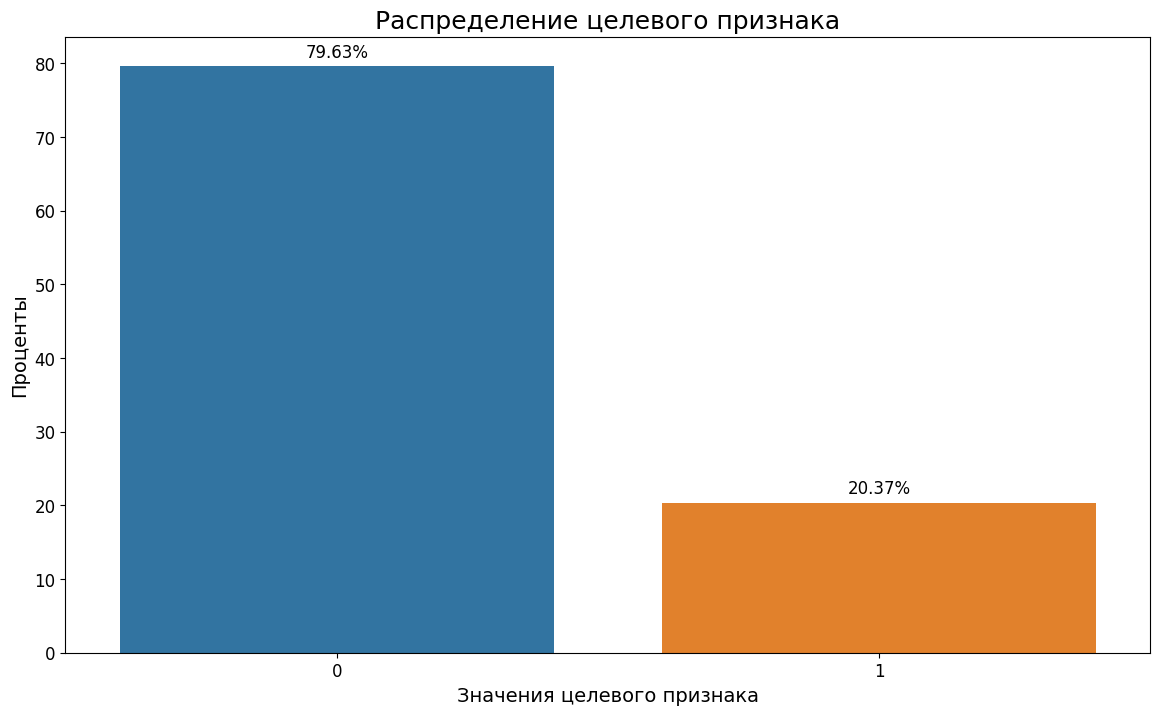

In [20]:
target_norm = df['exited'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

plt.figure(figsize=(14,8))
ax=sns.barplot(x='index', y='percent', data=target_norm) 

for i in ax.patches:
    text = '{:.2f}%'.format(i.get_height())
    ax.annotate(text, (i.get_x() + i.get_width() / 2, i.get_height()),
                ha = 'center',
                va='center',
                xytext=(0,10),
                textcoords='offset points',
                fontsize=12)

plt.title('Распределение целевого признака', fontsize=18)
plt.xlabel('Значения целевого признака', fontsize=14)
plt.ylabel('Проценты', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Сначала обучим модели регрессии, обучающего дерева и случайного леса без учета дисбаланса, а потом с учетом дисбаланса и сравним полученные результаты для принятия решения, какую модель использовать при обучении.

### Обучение моделей без учета дисбаланса  

Перед началом обучения напишем функции которые принимают на вход 3 параметра (значение гиперпараметра модели `class_weight`, признаки и целевой признак), а выводят метрики. 

In [21]:
# Напишем функцию для модели Логистической регрессии
def model_lr_func(class_weight, features, target):
    '''
    функция выводящая метрики модели Логистической Регрессии
    '''
    # Создадим модель
    model_lr = LogisticRegression(class_weight=class_weight, solver='liblinear')
    # Обучим модель на обучающей выборке
    model_lr.fit(features, target)
    # Получим предсказания модели
    predict_lr = model_lr.predict(features_valid)
    # Создадим массив предсказания дла ROC_AUC
    predict_score_lr = model_lr.predict_proba(features_valid)[:, 1]
    # Рассчитаем метрики
    precision_lr = precision_score(target_valid, predict_lr) # точность
    recall_lr = recall_score(target_valid, predict_lr) # полнота
    roc_auc_lr = roc_auc_score(target_valid, predict_score_lr) # roc_auc
    f1_lr = f1_score(target_valid, predict_lr) # f1-мера

    print("Логистическая регрессия:")
    print("Точность = {:.2f}, Полнота = {:.2f}, ROC_AUC= {:.2f}, f1-мера = {:.2f}".\
          format(precision_lr, recall_lr, roc_auc_lr, f1_lr))
    
    fpr, tpr, thresholds = roc_curve(target_valid, predict_score_lr) 

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [22]:
# Напишем функцию для модели Дерева Решений
def model_dtc_func(class_weight, features, target):
    '''
    Выводит метрики модели дерева решений глубиной от 1 до 15
    '''
    print("Дерево решений:")

    for max_depth in range(1, 16, 1):
        # Создадим модель
        model_dtc = DecisionTreeClassifier(class_weight=class_weight, max_depth=max_depth, random_state=RANDOM_STATE)
        # Обучим модель на обучающей выборке
        model_dtc.fit(features, target)
        # Получим предсказания модели
        predict_dtc = model_dtc.predict(features_valid)
        # Создадим массив предсказания дла ROC_AUC
        predict_score_dtc = model_dtc.predict_proba(features_valid)[:, 1]
        # Рассчитаем метрики
        precision_dtc = precision_score(target_valid, predict_dtc)
        recall_dtc = recall_score(target_valid, predict_dtc)
        roc_auc_dtc = roc_auc_score(target_valid, predict_score_dtc)
        f1_dtc = f1_score(target_valid, predict_dtc)

        print("Глубина дерева = {}: Точность = {:.2f}, Полнота = {:.2f}, ROC_AUC= {:.2f}, f1-мера = {:.2f}".\
          format(max_depth, precision_dtc, recall_dtc, roc_auc_dtc, f1_dtc))

In [23]:
# Напишем функцию для модели Случайного леса
def model_rfc_func(class_weight, features, target):
    '''
    Выводит метрики модели случайного леса, с количеством деревьев
    от 50 до 500 с шагом 50 и глубиной дерева 9
    '''
    print("Модель случайного леса:")

    for i in range(50, 501, 50):
        # Создадим модель
        model_rfc = RandomForestClassifier(class_weight=class_weight, n_estimators=i, max_depth=9, random_state=RANDOM_STATE)
        # Обучим модель на обучающей выборке
        model_rfc.fit(features, target)
        # Получим предсказания модели
        predict_rfc = model_rfc.predict(features_valid)
        # Создадим массив предсказания дла ROC_AUC
        predict_score_rfc = model_rfc.predict_proba(features_valid)[:, 1]
        # Рассчитаем метрики
        precision_rfc = precision_score(target_valid, predict_rfc)
        recall_rfc = recall_score(target_valid, predict_rfc)
        roc_auc_rfc = roc_auc_score(target_valid, predict_score_rfc)
        f1_rfc = f1_score(target_valid, predict_rfc)

        print("Кол-во деревьев = {}: Точность = {:.2f}, Полнота = {:.2f}, ROC_AUC= {:.2f}, f1-мера = {:.2f}".\
          format(i, precision_rfc, recall_rfc, roc_auc_rfc, f1_rfc))

Обучим модель логистической регрессии и выведем ее метрики:

Логистическая регрессия:
Точность = 0.57, Полнота = 0.24, ROC_AUC= 0.76, f1-мера = 0.33


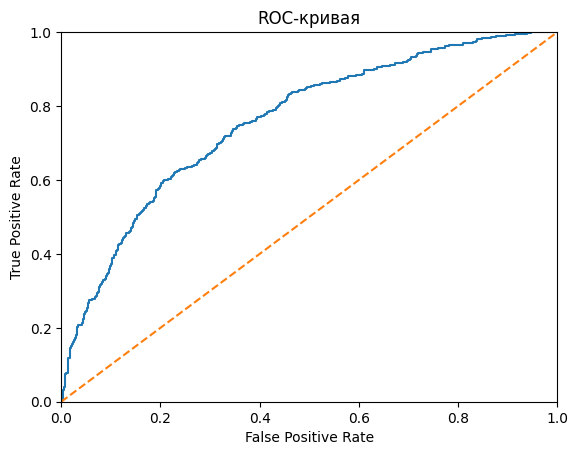

In [24]:
model_lr_func(None, features_train, target_train)

У модели логистической регрессии довольно низкие показатели полноты и *f1*-меры. Построим *ROC*-кривую (кривую ошибок) для определения на сколько сильно модель отличается от случайной.

Далее вызовем функцию с различной глубиной дерева модели дерева решений и также выведем метрики каждой глубины:

In [25]:
model_dtc_func(None, features_train, target_train)

Дерево решений:
Глубина дерева = 1: Точность = 0.00, Полнота = 0.00, ROC_AUC= 0.69, f1-мера = 0.00
Глубина дерева = 2: Точность = 0.60, Полнота = 0.46, ROC_AUC= 0.75, f1-мера = 0.52
Глубина дерева = 3: Точность = 0.83, Полнота = 0.28, ROC_AUC= 0.80, f1-мера = 0.42
Глубина дерева = 4: Точность = 0.75, Полнота = 0.44, ROC_AUC= 0.81, f1-мера = 0.55
Глубина дерева = 5: Точность = 0.78, Полнота = 0.41, ROC_AUC= 0.82, f1-мера = 0.54
Глубина дерева = 6: Точность = 0.78, Полнота = 0.45, ROC_AUC= 0.82, f1-мера = 0.57
Глубина дерева = 7: Точность = 0.77, Полнота = 0.41, ROC_AUC= 0.81, f1-мера = 0.53
Глубина дерева = 8: Точность = 0.74, Полнота = 0.43, ROC_AUC= 0.81, f1-мера = 0.55
Глубина дерева = 9: Точность = 0.68, Полнота = 0.48, ROC_AUC= 0.78, f1-мера = 0.56
Глубина дерева = 10: Точность = 0.66, Полнота = 0.46, ROC_AUC= 0.77, f1-мера = 0.54
Глубина дерева = 11: Точность = 0.58, Полнота = 0.47, ROC_AUC= 0.74, f1-мера = 0.52
Глубина дерева = 12: Точность = 0.56, Полнота = 0.48, ROC_AUC= 0.71, 

Наилушие покатели дерева решений наблюдаются при глубине дерева равной 6.

Теперь обучим модель случайного леса и получим ее метрики при различном количестве деревьев с глубиной дерева равной 9:

In [26]:
model_rfc_func(None, features_train, target_train)

Модель случайного леса:
Кол-во деревьев = 50: Точность = 0.82, Полнота = 0.44, ROC_AUC= 0.85, f1-мера = 0.57
Кол-во деревьев = 100: Точность = 0.80, Полнота = 0.42, ROC_AUC= 0.85, f1-мера = 0.55
Кол-во деревьев = 150: Точность = 0.82, Полнота = 0.44, ROC_AUC= 0.85, f1-мера = 0.57
Кол-во деревьев = 200: Точность = 0.81, Полнота = 0.44, ROC_AUC= 0.85, f1-мера = 0.57
Кол-во деревьев = 250: Точность = 0.82, Полнота = 0.43, ROC_AUC= 0.85, f1-мера = 0.57
Кол-во деревьев = 300: Точность = 0.82, Полнота = 0.44, ROC_AUC= 0.85, f1-мера = 0.58
Кол-во деревьев = 350: Точность = 0.83, Полнота = 0.44, ROC_AUC= 0.85, f1-мера = 0.57
Кол-во деревьев = 400: Точность = 0.83, Полнота = 0.44, ROC_AUC= 0.85, f1-мера = 0.58
Кол-во деревьев = 450: Точность = 0.83, Полнота = 0.44, ROC_AUC= 0.85, f1-мера = 0.57
Кол-во деревьев = 500: Точность = 0.83, Полнота = 0.44, ROC_AUC= 0.85, f1-мера = 0.58


Метрики модели случайного леса плюс-минусы одинаковые при различном количестве деревьев, наилучшие при количестве деревьев равном 400.

### Выводы  

* Целевой признак имеет дисбаланс классов равным 4 к 1, преобладание класса 0;
* Модель логистической регрессии без учета дисбаланса показала низкие показатели:   
Точность = 0.57, Полнота = 0.24, ROC_AUC= 0.76, f1-мера = 0.33;
* Модель дерева решений без учета дисбаланса показала наилучшие метрики при глубине дерева равной 6:  
Точность = 0.78, Полнота = 0.45, *ROC_AUC*= 0.82, *f1*-мера = 0.57.   
Показатель *f1*-меры практически достиг требуемой для проекта величины (0.59);
* Различное количество деревьев модели случайного леса не сильно оказывает влияние на метрики. Наилучшие показатели наблюдаются при 400 деревьях:   
Точность = 0.85, Полнота = 0.39, *ROC_AUC*= 0.85, *f1*-мера = 0.54.   
Показатель *f1*-меры также практически достиг требуемой для проекта величины (0.59);
* Пока что наилучшие результаты показывает модель дерева решений.

Улучшим качество моделей, учитывая дисбаланс классов и определим лучшую модель.

## Учет дисбаланса классов

Для балансировки классов предлагается проверить 3 разных метода:
1. Средствами самой модели: используем значение `balanced` для гиперпараметра `class_weight`
2. Используем **метод увеличения выборки** (*upsampling*) обучающих данных
3. Используем **метод уменьшениня выборки** (*downsampling*) обучающих данных

### Баланс классов при помощи гиперпараметра модели   

Повторим код из предыдущего пункта с изменив параметр `class_weight` на `balanced`  

**Логистическая регрессия:**

Логистическая регрессия:
Точность = 0.38, Полнота = 0.68, ROC_AUC= 0.76, f1-мера = 0.49


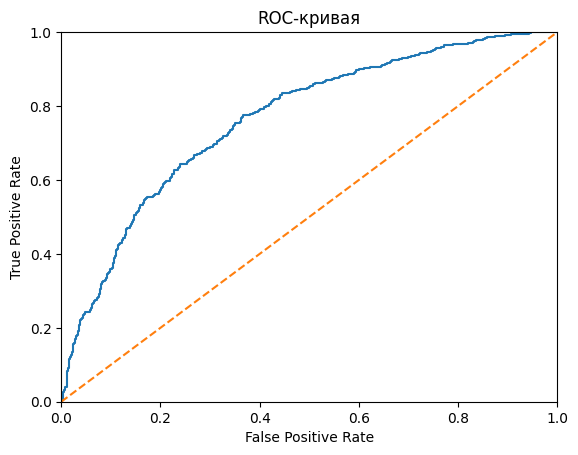

In [27]:
model_lr_func('balanced', features_train, target_train)

Качество модели улучшилось, но точность значительно упала.  

Определим важность признаков модели и построим график факторов ее важности:

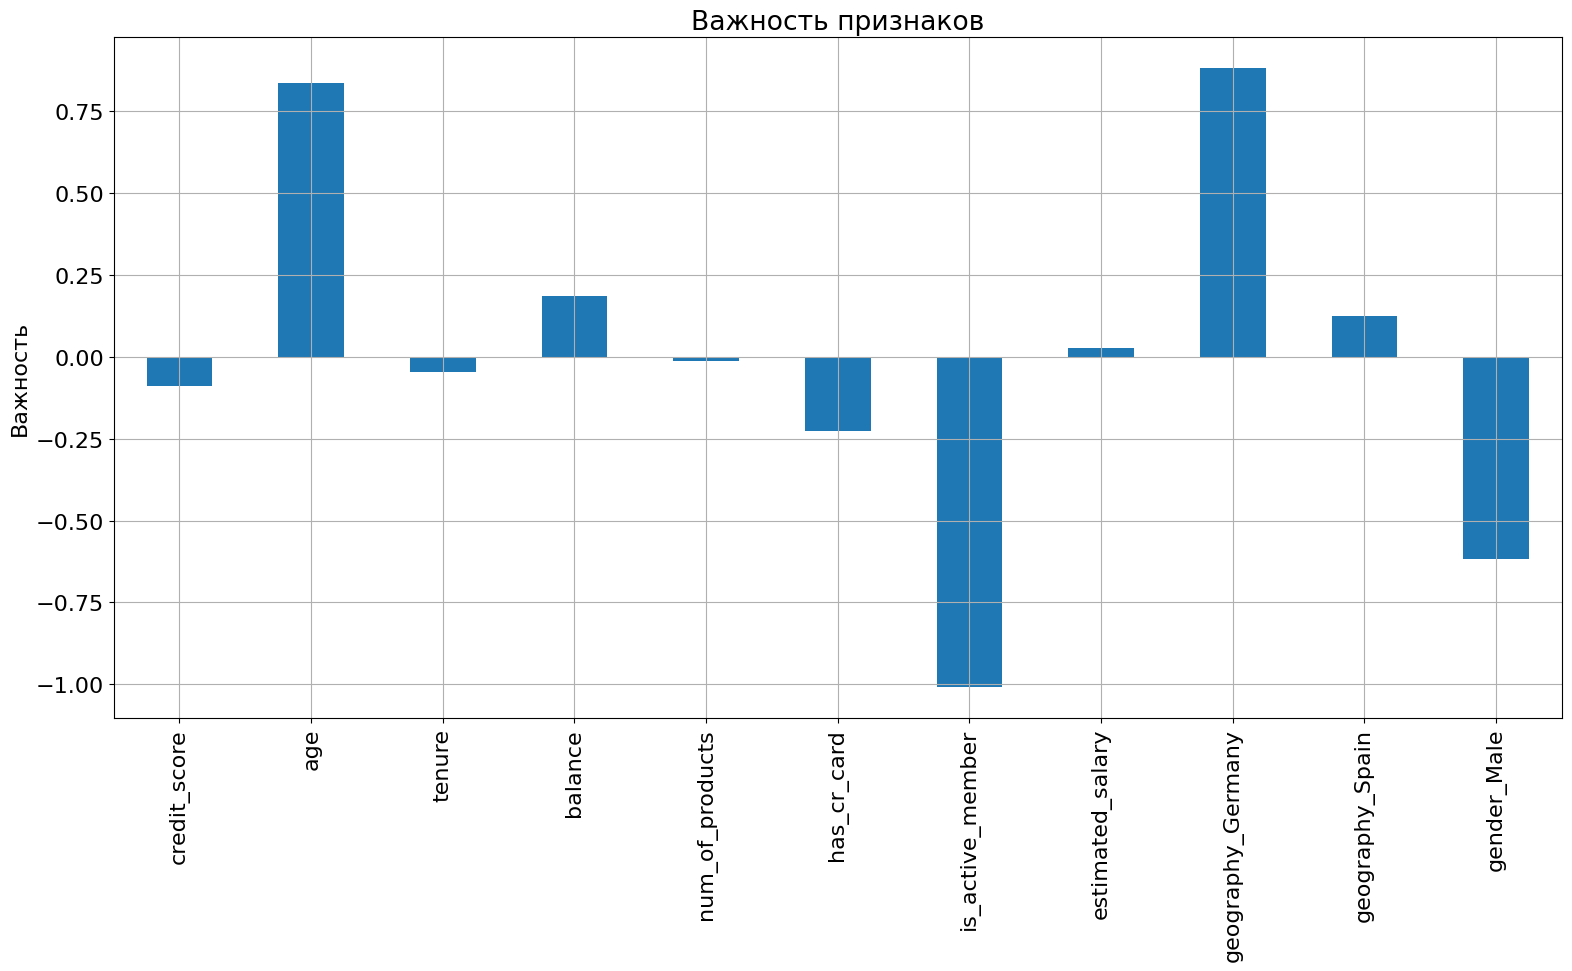

In [28]:
# Создадим модель
model_lr = LogisticRegression(class_weight='balanced', solver='liblinear')
# Обучим модель на обучающей выборке
model_lr.fit(features_train, target_train)
# Получим предсказания модели
predict_lr = model_lr.predict(features_valid)

lr_imp = pd.Series(model_lr.coef_[0],
                         features_train.columns)

plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(16,10))
lr_imp.plot.bar(ax=ax, grid=True)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

**Дерево решений:**

In [29]:
model_dtc_func('balanced', features_train, target_train)

Дерево решений:
Глубина дерева = 1: Точность = 0.44, Полнота = 0.59, ROC_AUC= 0.69, f1-мера = 0.50
Глубина дерева = 2: Точность = 0.46, Полнота = 0.66, ROC_AUC= 0.75, f1-мера = 0.54
Глубина дерева = 3: Точность = 0.46, Полнота = 0.66, ROC_AUC= 0.80, f1-мера = 0.54
Глубина дерева = 4: Точность = 0.40, Полнота = 0.77, ROC_AUC= 0.82, f1-мера = 0.53
Глубина дерева = 5: Точность = 0.54, Полнота = 0.67, ROC_AUC= 0.83, f1-мера = 0.60
Глубина дерева = 6: Точность = 0.46, Полнота = 0.71, ROC_AUC= 0.80, f1-мера = 0.56
Глубина дерева = 7: Точность = 0.47, Полнота = 0.67, ROC_AUC= 0.79, f1-мера = 0.55
Глубина дерева = 8: Точность = 0.45, Полнота = 0.67, ROC_AUC= 0.77, f1-мера = 0.54
Глубина дерева = 9: Точность = 0.46, Полнота = 0.65, ROC_AUC= 0.77, f1-мера = 0.54
Глубина дерева = 10: Точность = 0.43, Полнота = 0.63, ROC_AUC= 0.75, f1-мера = 0.51
Глубина дерева = 11: Точность = 0.47, Полнота = 0.61, ROC_AUC= 0.74, f1-мера = 0.53
Глубина дерева = 12: Точность = 0.44, Полнота = 0.61, ROC_AUC= 0.74, 

При глубине дерева равной 5 *f1*-мера имеет самый высокий показатель - 0.6.  

Определим важность признаков модели и построим график факторов ее важности для глубины дерева равной 5:

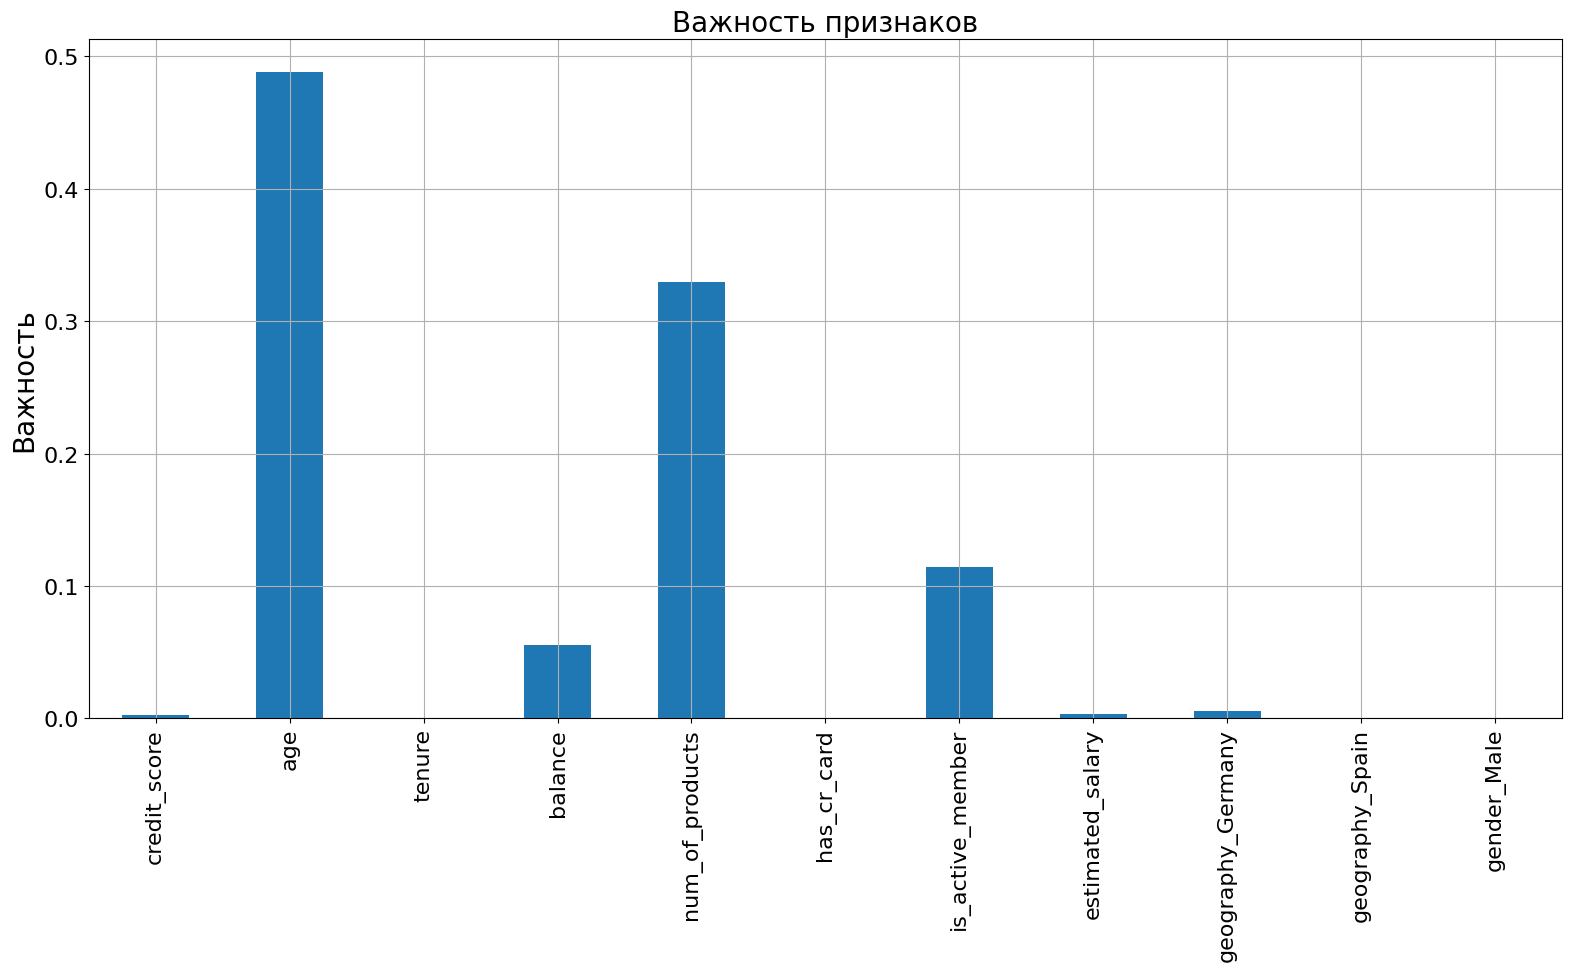

In [30]:
# Создадим модель
model_dtc = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=RANDOM_STATE)
# Обучим модель на обучающей выборке
model_dtc.fit(features_train, target_train)
# Получим предсказания модели
predict_dtc = model_dtc.predict(features_valid)

dtc_imp = pd.Series(model_dtc.feature_importances_,
                         features_train.columns)

plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(16,10))
dtc_imp.plot.bar(ax=ax, grid=True)
ax.set_title("Важность признаков", fontsize=20)
ax.set_ylabel('Важность', fontsize=20)
fig.tight_layout()

**Случайный лес**

In [31]:
model_rfc_func('balanced', features_train, target_train)

Модель случайного леса:
Кол-во деревьев = 50: Точность = 0.60, Полнота = 0.66, ROC_AUC= 0.85, f1-мера = 0.63
Кол-во деревьев = 100: Точность = 0.61, Полнота = 0.66, ROC_AUC= 0.86, f1-мера = 0.63
Кол-во деревьев = 150: Точность = 0.61, Полнота = 0.66, ROC_AUC= 0.86, f1-мера = 0.63
Кол-во деревьев = 200: Точность = 0.62, Полнота = 0.66, ROC_AUC= 0.86, f1-мера = 0.64
Кол-во деревьев = 250: Точность = 0.61, Полнота = 0.66, ROC_AUC= 0.86, f1-мера = 0.63
Кол-во деревьев = 300: Точность = 0.62, Полнота = 0.66, ROC_AUC= 0.86, f1-мера = 0.64
Кол-во деревьев = 350: Точность = 0.61, Полнота = 0.66, ROC_AUC= 0.86, f1-мера = 0.63
Кол-во деревьев = 400: Точность = 0.61, Полнота = 0.65, ROC_AUC= 0.86, f1-мера = 0.63
Кол-во деревьев = 450: Точность = 0.61, Полнота = 0.65, ROC_AUC= 0.86, f1-мера = 0.63
Кол-во деревьев = 500: Точность = 0.61, Полнота = 0.65, ROC_AUC= 0.86, f1-мера = 0.63


При количестве деревьев равном 200 *f1*-мера достигла значения 0.64.

Определим важность признаков модели и построим график факторов ее важности для глубины дерева равной 9 и количества деревьев равного 200:

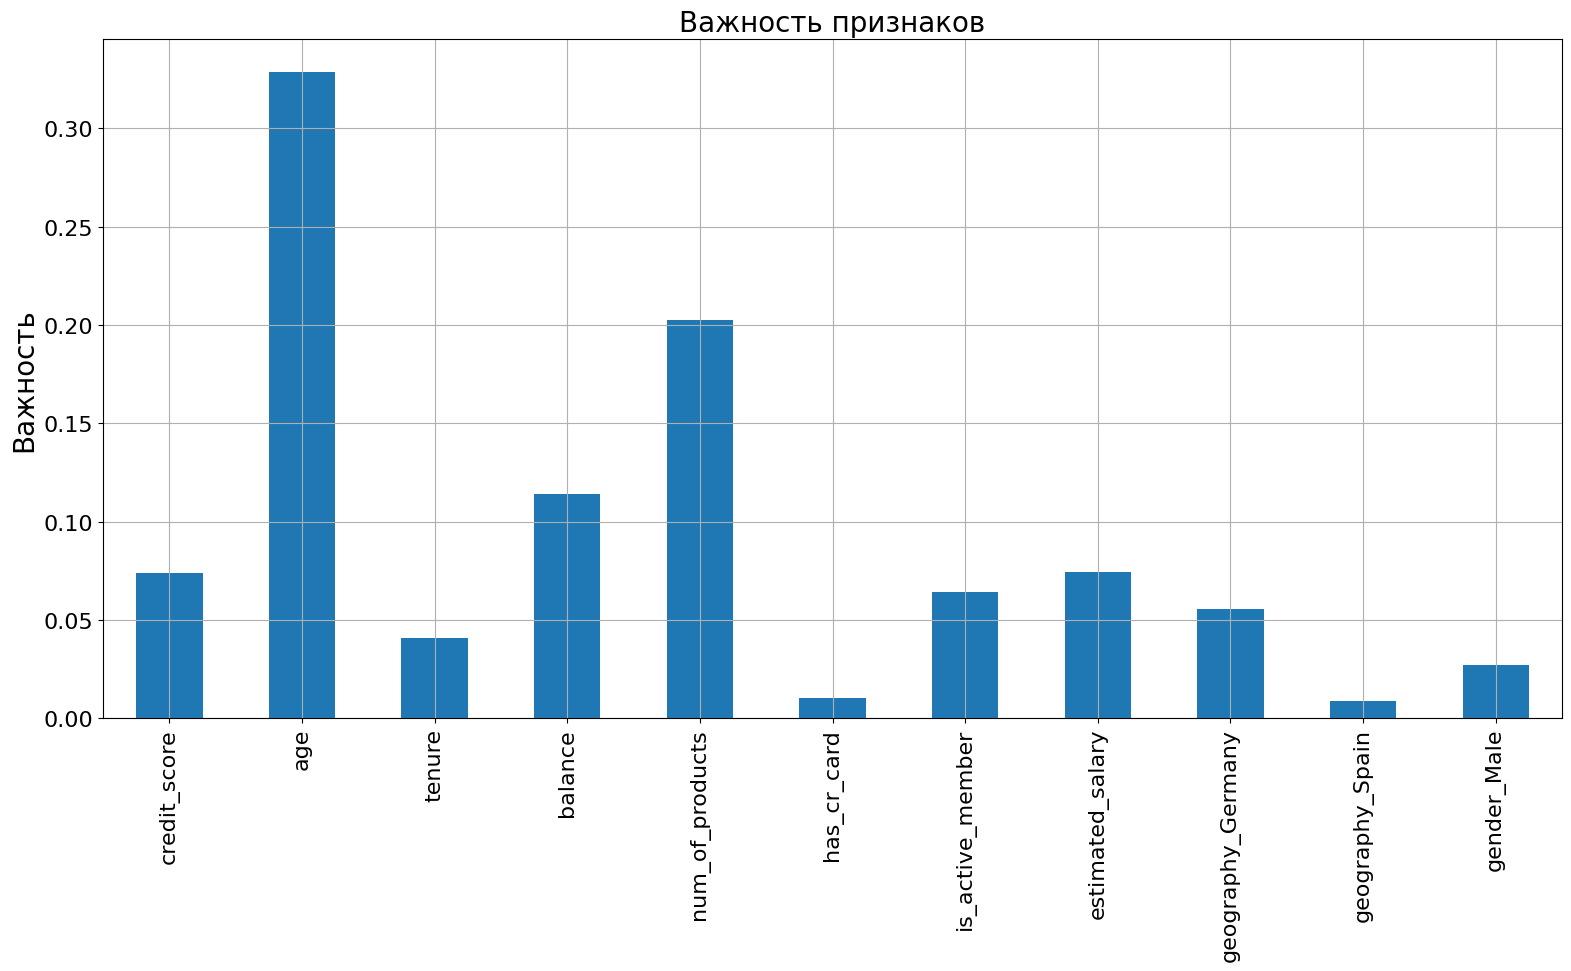

In [32]:
# Создадим модель
model_rfc = RandomForestClassifier(class_weight='balanced', n_estimators=200, max_depth=9, random_state=RANDOM_STATE)
# Обучим модель на обучающей выборке
model_rfc.fit(features_train, target_train)
# Получим предсказания модели
predict_rfc = model_rfc.predict(features_valid)

rfc_imp = pd.Series(model_rfc.feature_importances_,
                         features_train.columns)

plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(16,10))
rfc_imp.plot.bar(ax=ax, grid=True)
ax.set_title("Важность признаков", fontsize=20)
ax.set_ylabel('Важность', fontsize=20)
fig.tight_layout()

Так как метрики моделей Дерева решений и Случайного леса значительно лучше метрик модели Логистической регрессии, то сравним показатели важности этих двух моделей на одном графике:

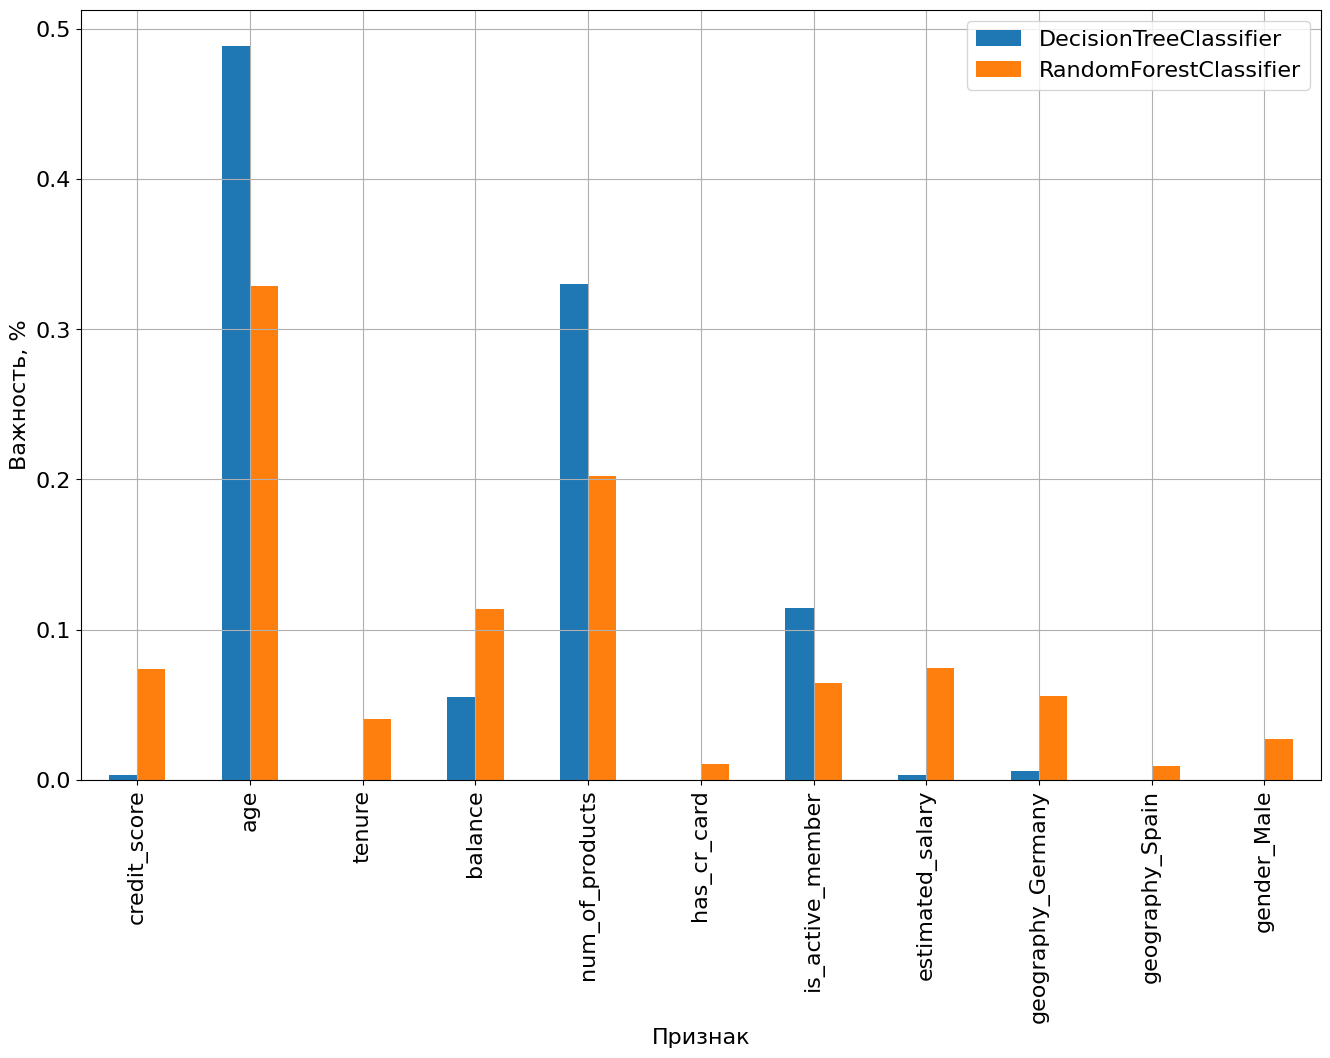

In [33]:
DF_churn = pd.DataFrame({'DecisionTreeClassifier' : model_dtc.feature_importances_,
                        'RandomForestClassifier'  : model_rfc.feature_importances_},
                       index=features_train.columns)

fig, ax = plt.subplots(figsize=(16,10))
ax = DF_churn.plot.bar(ax=ax, grid=True)
ax.set_xlabel('Признак')
ax.set_ylabel('Важность, %')
plt.show()

Как видим у моделей с наилучшими метриками важность признаков выражена совершенно по-разному. Модель дерева решений отдает предпочтения возрасту клиента (`age`) и количеству продуктов, используемых клиентом (`num_of_products`). Модель Случайного леса считает важность всех признаков более равномерно. Вероятно данный факт как раз влияет на качество модели.

При увеличении глубины дерева модели дерева решений график важности признаков становится более похожим на график модели Случайного леса. 

### Метод увеличения выборки (*upsampling*)  

Напишем функцию, которая возвращает сбалансированные выборки с помощью перемещивания

In [34]:
def upsample(features, target, repeat):
    '''
    Возвращает признаки и целевой признак после операции upsampling
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
          
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

Определим оптимальное количество повторений для работы функции:

In [35]:
if target_train[target_train == 0].shape[0] > target_train[target_train == 1].shape[0]:
    repeat = target_train[target_train == 0].shape[0] / target_train[target_train == 1].shape[0]
else:
    repeat = target_train[target_train == 1].shape[0] / target_train[target_train == 0].shape[0]

print(f'repeat = {repeat}')

# округлим до целого
repeat = round(repeat)

repeat = 4.016722408026756


Применим функцию к данным и проверим качество ее выполнения:

In [36]:
features_train_upsample, target_train_upsample = upsample(features_train, target_train, repeat)

print('Зачений с целевым признаком "0":', target_train_upsample[target_train_upsample == 0].shape[0])
print('Зачений с целевым признаком "1":', target_train_upsample[target_train_upsample == 1].shape[0])

Зачений с целевым признаком "0": 4804
Зачений с целевым признаком "1": 4784


Значений в данных практически поровну, значит они готовы для их проверки на моделях.  

**Логистическая регрессия:**

Логистическая регрессия:
Точность = 0.38, Полнота = 0.68, ROC_AUC= 0.76, f1-мера = 0.49


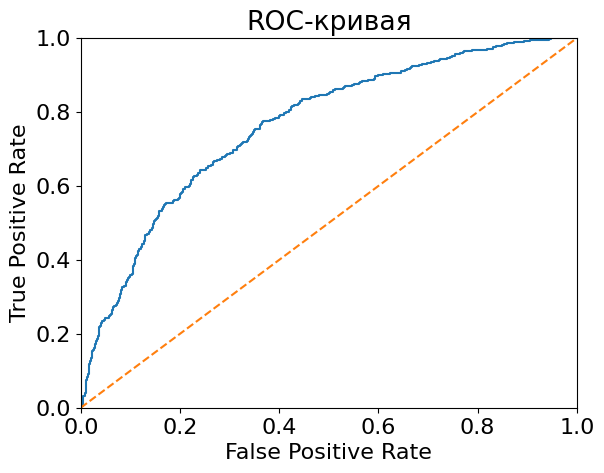

In [37]:
model_lr_func(None, features_train_upsample, target_train_upsample)

**Дерево решений**

In [38]:
model_dtc_func(None, features_train_upsample, target_train_upsample)

Дерево решений:
Глубина дерева = 1: Точность = 0.44, Полнота = 0.59, ROC_AUC= 0.69, f1-мера = 0.50
Глубина дерева = 2: Точность = 0.46, Полнота = 0.66, ROC_AUC= 0.75, f1-мера = 0.54
Глубина дерева = 3: Точность = 0.46, Полнота = 0.66, ROC_AUC= 0.80, f1-мера = 0.54
Глубина дерева = 4: Точность = 0.40, Полнота = 0.77, ROC_AUC= 0.82, f1-мера = 0.53
Глубина дерева = 5: Точность = 0.54, Полнота = 0.67, ROC_AUC= 0.83, f1-мера = 0.60
Глубина дерева = 6: Точность = 0.46, Полнота = 0.71, ROC_AUC= 0.80, f1-мера = 0.56
Глубина дерева = 7: Точность = 0.47, Полнота = 0.67, ROC_AUC= 0.79, f1-мера = 0.55
Глубина дерева = 8: Точность = 0.46, Полнота = 0.67, ROC_AUC= 0.77, f1-мера = 0.54
Глубина дерева = 9: Точность = 0.46, Полнота = 0.65, ROC_AUC= 0.77, f1-мера = 0.54
Глубина дерева = 10: Точность = 0.43, Полнота = 0.64, ROC_AUC= 0.75, f1-мера = 0.52
Глубина дерева = 11: Точность = 0.48, Полнота = 0.61, ROC_AUC= 0.75, f1-мера = 0.54
Глубина дерева = 12: Точность = 0.45, Полнота = 0.60, ROC_AUC= 0.73, 

**Случайный лес**

In [39]:
model_rfc_func(None, features_train_upsample, target_train_upsample)

Модель случайного леса:
Кол-во деревьев = 50: Точность = 0.56, Полнота = 0.70, ROC_AUC= 0.85, f1-мера = 0.62
Кол-во деревьев = 100: Точность = 0.56, Полнота = 0.71, ROC_AUC= 0.85, f1-мера = 0.63
Кол-во деревьев = 150: Точность = 0.56, Полнота = 0.70, ROC_AUC= 0.85, f1-мера = 0.62
Кол-во деревьев = 200: Точность = 0.56, Полнота = 0.70, ROC_AUC= 0.85, f1-мера = 0.62
Кол-во деревьев = 250: Точность = 0.56, Полнота = 0.69, ROC_AUC= 0.85, f1-мера = 0.62
Кол-во деревьев = 300: Точность = 0.56, Полнота = 0.70, ROC_AUC= 0.85, f1-мера = 0.62
Кол-во деревьев = 350: Точность = 0.56, Полнота = 0.70, ROC_AUC= 0.85, f1-мера = 0.62
Кол-во деревьев = 400: Точность = 0.56, Полнота = 0.70, ROC_AUC= 0.85, f1-мера = 0.62
Кол-во деревьев = 450: Точность = 0.56, Полнота = 0.70, ROC_AUC= 0.85, f1-мера = 0.62
Кол-во деревьев = 500: Точность = 0.56, Полнота = 0.70, ROC_AUC= 0.85, f1-мера = 0.62


Значение метрик метода увеличения выборки получилось практически такое же как после балансировки при помощи гиперпараметра: для логистической регрессии метрики остались неизменными, а для дерева решений и случайного леса несколько ухудшились.

### Метод уменьшения выборки (*downsampling*)  

Напишем функцию, которая возвращает сбалансированные выборки с помощью перемещивания

In [40]:
def downsample(features, target, fraction):
    '''
    Возвращает признаки и целевой признак после операции downsampling
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=666)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=666)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=666)
    
    return features_downsampled, target_downsampled

Определим оптимальную долю отрицательных объектов, которую нужно сохранить:

In [41]:
if target_train[target_train == 0].shape[0] < target_train[target_train == 1].shape[0]:
    fraction = target_train[target_train == 0].shape[0] / target_train[target_train == 1].shape[0]
else:
    fraction = target_train[target_train == 1].shape[0] / target_train[target_train == 0].shape[0]

print(f'fraction = {fraction}')

fraction = 0.24895920066611157


Применим функцию к данным и проверим качество ее выполнения:

In [42]:
features_train_downsample, target_train_downsample = downsample(features_train, target_train, fraction)

print('Зачений с целевым признаком "0":', target_train_downsample[target_train_downsample == 0].shape[0])
print('Зачений с целевым признаком "1":', target_train_downsample[target_train_downsample == 1].shape[0])

Зачений с целевым признаком "0": 1196
Зачений с целевым признаком "1": 1196


Данные готовы для проверки на моделях.  

**Логистическая регрессия:**

Логистическая регрессия:
Точность = 0.38, Полнота = 0.68, ROC_AUC= 0.76, f1-мера = 0.49


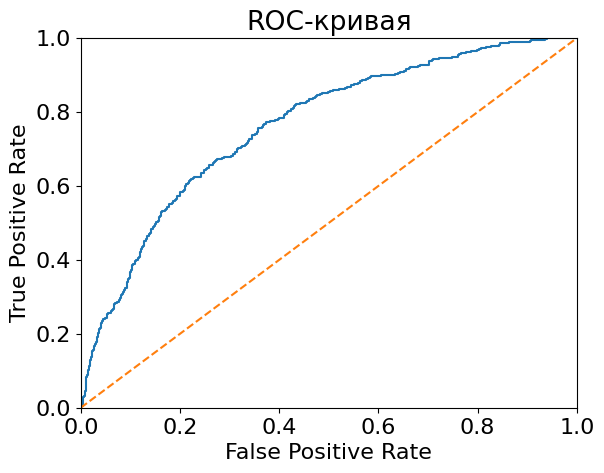

In [43]:
model_lr_func(None, features_train_downsample, target_train_downsample)

**Дерево решений:**

In [44]:
model_dtc_func(None, features_train_downsample, target_train_downsample)

Дерево решений:
Глубина дерева = 1: Точность = 0.44, Полнота = 0.59, ROC_AUC= 0.69, f1-мера = 0.50
Глубина дерева = 2: Точность = 0.46, Полнота = 0.66, ROC_AUC= 0.75, f1-мера = 0.54
Глубина дерева = 3: Точность = 0.46, Полнота = 0.66, ROC_AUC= 0.80, f1-мера = 0.54
Глубина дерева = 4: Точность = 0.47, Полнота = 0.71, ROC_AUC= 0.82, f1-мера = 0.56
Глубина дерева = 5: Точность = 0.45, Полнота = 0.75, ROC_AUC= 0.83, f1-мера = 0.56
Глубина дерева = 6: Точность = 0.46, Полнота = 0.76, ROC_AUC= 0.83, f1-мера = 0.57
Глубина дерева = 7: Точность = 0.47, Полнота = 0.67, ROC_AUC= 0.80, f1-мера = 0.55
Глубина дерева = 8: Точность = 0.43, Полнота = 0.71, ROC_AUC= 0.79, f1-мера = 0.54
Глубина дерева = 9: Точность = 0.45, Полнота = 0.68, ROC_AUC= 0.77, f1-мера = 0.54
Глубина дерева = 10: Точность = 0.41, Полнота = 0.69, ROC_AUC= 0.74, f1-мера = 0.51
Глубина дерева = 11: Точность = 0.40, Полнота = 0.69, ROC_AUC= 0.72, f1-мера = 0.50
Глубина дерева = 12: Точность = 0.37, Полнота = 0.65, ROC_AUC= 0.70, 

**Случайный лес:**

In [45]:
model_rfc_func(None, features_train_downsample, target_train_downsample)

Модель случайного леса:
Кол-во деревьев = 50: Точность = 0.50, Полнота = 0.76, ROC_AUC= 0.85, f1-мера = 0.61
Кол-во деревьев = 100: Точность = 0.50, Полнота = 0.76, ROC_AUC= 0.85, f1-мера = 0.60
Кол-во деревьев = 150: Точность = 0.50, Полнота = 0.75, ROC_AUC= 0.85, f1-мера = 0.60
Кол-во деревьев = 200: Точность = 0.50, Полнота = 0.75, ROC_AUC= 0.85, f1-мера = 0.60
Кол-во деревьев = 250: Точность = 0.50, Полнота = 0.75, ROC_AUC= 0.85, f1-мера = 0.60
Кол-во деревьев = 300: Точность = 0.50, Полнота = 0.75, ROC_AUC= 0.85, f1-мера = 0.60
Кол-во деревьев = 350: Точность = 0.50, Полнота = 0.75, ROC_AUC= 0.85, f1-мера = 0.60
Кол-во деревьев = 400: Точность = 0.50, Полнота = 0.75, ROC_AUC= 0.85, f1-мера = 0.60
Кол-во деревьев = 450: Точность = 0.51, Полнота = 0.75, ROC_AUC= 0.85, f1-мера = 0.61
Кол-во деревьев = 500: Точность = 0.51, Полнота = 0.75, ROC_AUC= 0.85, f1-мера = 0.61


Значение метрик метода уменьшения выборки получилось несколько хуже, чем после балансировки при помощи гиперпараметра и после увеличения выборки: для логистической регрессии метрики остались неизменными, а для дерева решений и случайного леса ухудшились.

### Выводы и определение лучшей модели  

Исходя из проведенного исследования для каждой модели можно сделать следующие выводы:
* Логистическая регрессия: 
    * показала себя более чувствительной к дисбалансу классов;
    * наилучшие и в то же время одинаковые результаты получились при помощи балансировки классов с помощью гиперпараметра модели, а также при методах увеличения и уменьшения выборки;
    * при устранении дисбаланса точность модели понизилась, но качество значительно выросло.
* Модель решающего дерева:
    * при дисбалансе классов целевого признака показала наилучший результат, но после устранения дисбаланса проиграла модели случайного леса;
    * при методе устранения дисбаланса с помощью гиперпараметра модели и при методе увеличения выборки показала наилучшую *f1*-меру равную 0.6;
    * при методе устранения дисбаланса с помощью уменьшения выборки качество незначительно ухудшилось и наибольшее значение *f1*-меры получилось равным 0.57;
    * таким образом при масштабировании качество модели несколько падает в связи с тем, что модель чаще предсказывает класс 1, при этом количество ложно-положительных результатов тоже растёт.
* Модель случайного леса:
    * без учета дисбаланса классов показала результат хуже, чем у решающего дерева;
    * с учетом дисбаланса классов показала наивысшие результаты, при этом самого высокого качества удалось достичь при балансировке с помощью гиперпараметра модели.   
    
Таким образом, устранив дисбаланс классов целевого признака наглядно видно, что наилучшие метрики показывает модель **случайного леса** с гиперпараметром модели `class_weight='balanced'`. Далее будем подбирать оптимальные параметры для данной модели.

### Улучшение модели 

Для подбора оптимальных параметров будем использовать метод `GridSearchCV` из библиотеки `sklearn`. Чтобы не обучать большое количество моделей используем логарифмическую сетку параметров:

In [46]:
parametrs = { 'n_estimators': range (50, 501, 50),
              'max_depth': range (1, 13, 2) }

In [47]:
clf = RandomForestClassifier()

In [48]:
grid = GridSearchCV(clf, parametrs, cv=5, scoring='f1')
grid.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 13, 2),
                         'n_estimators': range(50, 501, 50)},
             scoring='f1')

In [49]:
grid.best_params_

{'max_depth': 11, 'n_estimators': 200}

### Обучение модели  

Для получения наилучшего результата подберем параметр порогового значения, отвечающего за присваивание предсказанию класса 0 или 1.

In [55]:
# Создадим модель
model = RandomForestClassifier(n_estimators=200,
                               max_depth=11,
                               class_weight='balanced',
                               random_state=RANDOM_STATE)

# Обучим модель на подготовленных данных
model.fit(features_train, target_train)

# Получим предсказания модели
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Напишем цикл перебора порога с выводом метрик
for threshold in np.arange(0, 0.8, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    print("Порог = {:.2f}: Точность = {:.2f}, Полнота = {:.2f}, ROC_AUC = {:.2f}, f1 = {:.2f}".\
          format(threshold, precision, recall, roc_auc, f1))

Порог = 0.00: Точность = 0.21, Полнота = 1.00, ROC_AUC = 0.85, f1 = 0.35
Порог = 0.05: Точность = 0.23, Полнота = 0.99, ROC_AUC = 0.85, f1 = 0.38
Порог = 0.10: Точность = 0.27, Полнота = 0.96, ROC_AUC = 0.85, f1 = 0.42
Порог = 0.15: Точность = 0.30, Полнота = 0.93, ROC_AUC = 0.85, f1 = 0.46
Порог = 0.20: Точность = 0.35, Полнота = 0.89, ROC_AUC = 0.85, f1 = 0.50
Порог = 0.25: Точность = 0.40, Полнота = 0.85, ROC_AUC = 0.85, f1 = 0.55
Порог = 0.30: Точность = 0.46, Полнота = 0.79, ROC_AUC = 0.85, f1 = 0.58
Порог = 0.35: Точность = 0.51, Полнота = 0.72, ROC_AUC = 0.85, f1 = 0.60
Порог = 0.40: Точность = 0.57, Полнота = 0.69, ROC_AUC = 0.85, f1 = 0.62
Порог = 0.45: Точность = 0.61, Полнота = 0.62, ROC_AUC = 0.85, f1 = 0.62
Порог = 0.50: Точность = 0.65, Полнота = 0.58, ROC_AUC = 0.85, f1 = 0.61
Порог = 0.55: Точность = 0.72, Полнота = 0.54, ROC_AUC = 0.85, f1 = 0.61
Порог = 0.60: Точность = 0.77, Полнота = 0.48, ROC_AUC = 0.85, f1 = 0.59
Порог = 0.65: Точность = 0.82, Полнота = 0.43, ROC_

Видно, что оптимальное значение порога равно 0.4 - 0.45 (также как по умолчанию). Выведем значения метрики качества модели *f1_score* отдельно:

In [56]:
prediction_valid = model.predict_proba(features_valid)
probabilities_one_valid = prediction_valid[:, 1]
predicted_valid = probabilities_one_valid > 0.4
f1 = f1_score(target_valid, predicted_valid)

print("f1_score = {:.2f}".format(f1))

f1_score = 0.62


## Тестирование модели  

Обучим финальную модель и проверим ее качество на тестовой выборке:

In [57]:
model_final = RandomForestClassifier(n_estimators=400, max_depth=11, class_weight='balanced', random_state=RANDOM_STATE)
model_final.fit(features_train, target_train)
predicted_test = model_final.predict(features_test)
print(f1_score(target_test, predicted_test))

0.6017925736235595


Удалось достигнуть заданного значения *f1*-меры.  

Посчитаем площадь под *ROC*-кривой (метрика *AUC_ROC*), чтобы выяснить насколько ее точность отличается от случайной.

In [58]:
probabilities_test_final = model_final.predict_proba(features_test)
probabilities_one_test_final = probabilities_test_final[:, 1]
print(roc_auc_score(target_test, probabilities_one_test_final))

0.8583164310845472


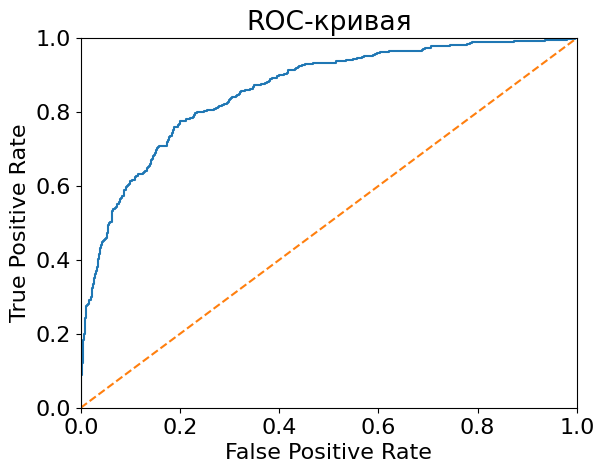

In [59]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_final) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Выводы после тестирования  

* В ходе выполнения работы изучили исходные данные и подготовили их к исследованию:
    * обработали пропуски в столбце `tenure`;
    * преобразовали категориальные признаки в численные при помощи техники прямого кодирования (*OHE*);
    * обозначили признаки и целевой признак, а также стандартизировали их;
* Провели исследование баланса классов целевого признака, в ходе которого выяснили, что данные несбалансированы. Без учета дисбаланса определили лучшую модель - Дерево решений;
* Применили 3 метода борьбы с дисбаласом (параметр `class_weight='balanced'`, метод увеличения выборки и метод уменьшения выборки), а также выбрали науличший метод и модель - случайного леса
* Определили наилушие гиперпараметры модели и выдели ее метрики;
* Обучили финальную модель и проверили ее качество на тестовой выборке: *f1*-мера достигла значения 0.6, что превышает заданное Заказчиком значение (0.59);
* Значение метрики *AUC_ROC* значительно превысило значение 0.5 и составило 0.85, что означает, что построенная модель  отличается от значения случайной модели, то есть предсказывает больше половины уходов клиента из банка.

Таким образом удалось достичь главную цель проекта и построить модель требуемого качества.